In [7]:
%matplotlib inline
import os, sys, gc
import shutil
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from matplotlib import gridspec
import matplotlib.image as mpimg

from scipy.stats import pearsonr as pr

import collections


def get_model_scores(model_predictions, human_predictions):
    """Returns second best accuracy scores"""
    total = model_predictions.shape[0]

    model_guesses = np.argsort(model_predictions, axis = 1)[:, -2: ]
    model_second_guesses = model_guesses[:, 0]
    model_top_guesses = model_guesses[:, 1]
    
    human_guesses = np.argsort(human_predictions, axis = 1)[:, -2: ]
    human_second_guesses = human_guesses[:, 0]
    human_top_guesses = human_guesses[:, 1]
                                      
    matches = model_top_guesses == human_top_guesses
    #print('total', total)
    #print('model_top_guesses', model_top_guesses)
    #print('model_second_guesses', model_second_guesses)
    #print('human_top_guesses', human_top_guesses)
    #print('human_second_guesses', human_second_guesses)
    #print('matches', matches)
    accuracy = np.sum(matches)
    mean_accuracy = np.mean(matches)
    correct_total = accuracy
    incorrect_total = total - accuracy
    
    #print('overall model accuracy: ', mean_accuracy)
    #print('correct total: ', correct_total)
    #print('incorrect total: ', incorrect_total)

    incorrect_sba = 0
    correct_sba = 0
    total_sba = 0
    
    for i, match in enumerate(matches):
        model_first = model_top_guesses[i]
        human_first = human_top_guesses[i]
        model_second = model_second_guesses[i]
        human_second = human_second_guesses[i]
        
        total_sba += model_second == human_second
        
        if match == True:
            correct_sba += model_second == human_second
        elif match == False:
            incorrect_sba += model_second == human_first
            
    return {'mean_accuracy': mean_accuracy, 
            'total_sba': total_sba / total, 
            'correct_sba': correct_sba / correct_total, 
            'incorrect_sba': incorrect_sba / incorrect_total}
#                 # both c     #top c     # top i     # both i
#humans = np.array([[1, 2, 3], [1, 3, 2], [2, 1, 3], [2, 3, 1]])
#models = np.array([[1, 2, 3], [2, 3, 1], [2, 3, 1], [1, 2, 3]])

# should be 2 /4 (50%) correct, 2 /4 (50%) total sba, 
#1 /2 (50%) correct sba, 1 /2 (50%) incorrect sba
#print(get_model_scores(models, humans))


{'mean_accuracy': 0.5, 'total_sba': 0.5, 'correct_sba': 0.5, 'incorrect_sba': 0.5}


In [11]:
loadDir = 'base_predictions'
postDir = 'post'
saveDir = 'figures'
# raw bins
bins = np.load('{0}/human_bincounts.npy'.format(loadDir))
#correct = np.argmax(bins, axis = 1)
#print(correct[:5])
#raw probabilities
humans = bins / np.sum(bins, axis = 1)[:, np.newaxis]
max_prob = np.max(humans, axis = 1)
humans_correct = np.argmax(humans, axis = 1)
humans_smoothed = (bins + 1) / np.sum(bins, axis = 1)[:, np.newaxis]

validation_idx = np.load('./val_idx_seed_0.npy')
print('val idx shape: ', validation_idx.shape)

ordered_filenames = np.load('{0}/decoded_test_filename_order.npy'.format(loadDir))

labels = ['P', 'A', 'B', 'C', 'De', 'Do', 'F', 'H', 'S', 'T']

im_dir = '/home/battleday/Academic/Berkeley/Superman/local/images/train_set_combined'

val idx shape:  (1000,)


In [3]:
np.shape(np.intersect1d(validation_idx, np.arange(10000)))

(1000,)

In [4]:
test_files = os.listdir('{0}/test/'.format(loadDir))
print(test_files)
test_files = sorted([p for p in test_files if p[-4:] == '.npz'])
print(test_files)
test_files.remove('resnet_preact_bottleneck_164_test.npz')
print(test_files)

test_dict = collections.OrderedDict()
for m in test_files:
    raw = np.load('{0}/test/{1}'.format(loadDir, m))
    model = m.split('.')[0]
    test_dict[model] = {}
    for prop in raw.keys(): 
        test_dict[model][prop] = raw[prop]
print(test_dict.keys())


['resnext_29_8x64d_test.npz', 'resnet_preact_bottleneck_164_test.npz', 'densenet_BC_100_12_test.npz', 'vgg_15_BN_64_test.npz', 'pyramidnet_basic_110_270_test.npz', 'wrn_28_10_test.npz', 'shake_shake_26_2x64d_SSI_cutout16_test.npz', 'resnet_basic_110_test.npz']
['densenet_BC_100_12_test.npz', 'pyramidnet_basic_110_270_test.npz', 'resnet_basic_110_test.npz', 'resnet_preact_bottleneck_164_test.npz', 'resnext_29_8x64d_test.npz', 'shake_shake_26_2x64d_SSI_cutout16_test.npz', 'vgg_15_BN_64_test.npz', 'wrn_28_10_test.npz']
['densenet_BC_100_12_test.npz', 'pyramidnet_basic_110_270_test.npz', 'resnet_basic_110_test.npz', 'resnext_29_8x64d_test.npz', 'shake_shake_26_2x64d_SSI_cutout16_test.npz', 'vgg_15_BN_64_test.npz', 'wrn_28_10_test.npz']
odict_keys(['densenet_BC_100_12_test', 'pyramidnet_basic_110_270_test', 'resnet_basic_110_test', 'resnext_29_8x64d_test', 'shake_shake_26_2x64d_SSI_cutout16_test', 'vgg_15_BN_64_test', 'wrn_28_10_test'])


In [5]:
post_files = os.listdir('{0}/'.format(postDir))
#print(post_files)
post_files = sorted([p for p in post_files if p[-4:] == '.npz'])
#print(post_files)

post_dict = collections.OrderedDict()
for m in post_files:
    raw = np.load('{0}/{1}'.format(postDir, m))
    model = m.split('.')[0]
    post_dict[model] = {}
    for prop in raw.keys(): 
        post_dict[model][prop] = raw[prop]
print(post_dict.keys())



odict_keys(['densenet_BC_100_12_test', 'pyramidnet_basic_110_270_test', 'resnet_basic_110_test', 'resnet_basic_110_train', 'resnext_29_8x64d_test', 'shake_shake_26_2x64d_SSI_cutout16_test', 'vgg_15_BN_64_test', 'vgg_15_BN_64_train', 'wrn_28_10_test', 'wrn_28_10_train'])


In [17]:
accuracies = []
sbas = []
i_sbas = []
c_sbas = []
models = []

for model, value in test_dict.items():
    print(model)
    models.append(model)
    print(humans.shape)
    humans_val = humans.copy()[validation_idx]
    print(humans_val.shape)
    model_val = value['probs'][validation_idx]
    print(model_val.shape)
    value['scores'] = get_model_scores(model_val, 
                                       humans_val)
    for k, v in value['scores'].items():
        print(k, v)
        
    accuracies.append(value['scores']['mean_accuracy'])
    sbas.append(value['scores']['total_sba'])
    i_sbas.append(value['scores']['incorrect_sba'])
    c_sbas.append(value['scores']['correct_sba'])
    


densenet_BC_100_12_test
(10000, 10)
(1000, 10)
(1000, 10)
mean_accuracy 0.961
total_sba 0.264
correct_sba 0.270551508845
incorrect_sba 0.74358974359
pyramidnet_basic_110_270_test
(10000, 10)
(1000, 10)
(1000, 10)
mean_accuracy 0.966
total_sba 0.238
correct_sba 0.245341614907
incorrect_sba 0.617647058824
resnet_basic_110_test
(10000, 10)
(1000, 10)
(1000, 10)
mean_accuracy 0.942
total_sba 0.236
correct_sba 0.246284501062
incorrect_sba 0.637931034483
resnext_29_8x64d_test
(10000, 10)
(1000, 10)
(1000, 10)
mean_accuracy 0.965
total_sba 0.258
correct_sba 0.266321243523
incorrect_sba 0.628571428571
shake_shake_26_2x64d_SSI_cutout16_test
(10000, 10)
(1000, 10)
(1000, 10)
mean_accuracy 0.967
total_sba 0.286
correct_sba 0.29265770424
incorrect_sba 0.666666666667
vgg_15_BN_64_test
(10000, 10)
(1000, 10)
(1000, 10)
mean_accuracy 0.944
total_sba 0.239
correct_sba 0.25
incorrect_sba 0.625
wrn_28_10_test
(10000, 10)
(1000, 10)
(1000, 10)
mean_accuracy 0.955
total_sba 0.265
correct_sba 0.27643979057

In [19]:
accuracies_post = []
sbas_post = []
i_sbas_post = []
c_sbas_post = []
models_post = []
for model, value in post_dict.items():
    print(model)
    models_post.append(model)
    print(humans.shape)
    humans_val = humans.copy()[validation_idx]
    print(humans_val.shape)
    model_val = value['probs'][validation_idx]
    print(model_val.shape)
    value['scores'] = get_model_scores(model_val, 
                                       humans_val)
    for k, v in value['scores'].items():
        print(k, v)
        
    accuracies_post.append(value['scores']['mean_accuracy'])
    sbas_post.append(value['scores']['total_sba'])
    i_sbas_post.append(value['scores']['incorrect_sba'])
    c_sbas_post.append(value['scores']['correct_sba'])

densenet_BC_100_12_test
(10000, 10)
(1000, 10)
(1000, 10)
mean_accuracy 0.945
total_sba 0.307
correct_sba 0.321693121693
incorrect_sba 0.763636363636
pyramidnet_basic_110_270_test
(10000, 10)
(1000, 10)
(1000, 10)
mean_accuracy 0.96
total_sba 0.325
correct_sba 0.336458333333
incorrect_sba 0.825
resnet_basic_110_test
(10000, 10)
(1000, 10)
(1000, 10)
mean_accuracy 0.935
total_sba 0.3
correct_sba 0.316577540107
incorrect_sba 0.676923076923
resnet_basic_110_train
(10000, 10)
(1000, 10)
(1000, 10)
mean_accuracy 0.098
total_sba 0.111
correct_sba 0.244897959184
incorrect_sba 0.10421286031
resnext_29_8x64d_test
(10000, 10)
(1000, 10)
(1000, 10)
mean_accuracy 0.962
total_sba 0.329
correct_sba 0.335758835759
incorrect_sba 0.657894736842
shake_shake_26_2x64d_SSI_cutout16_test
(10000, 10)
(1000, 10)
(1000, 10)
mean_accuracy 0.969
total_sba 0.347
correct_sba 0.357069143447
incorrect_sba 0.806451612903
vgg_15_BN_64_test
(10000, 10)
(1000, 10)
(1000, 10)
mean_accuracy 0.937
total_sba 0.318
correct_s

['densenet BC 100 12', 'pyramidnet basic 110 270', 'resnet basic 110', 'resnet basic 110', 'resnext 29 8x64d', 'shake shake 26 2x64d SSI cutout16', 'vgg 15 BN 64', 'vgg 15 BN 64', 'wrn 28 10', 'wrn 28 10']
10 7


ValueError: x and y must have same first dimension, but have shapes (10,) and (7,)

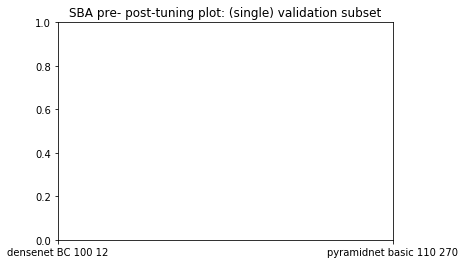

In [23]:
models_new = [(' ').join(x.split('_')[:-1]) for x in models_post]
print(models_new)
print(len(models_new), len(accuracies))
plt.figure()
plt.title('SBA pre- post-tuning plot: (single) validation subset')
plt.ylim([0, 1])
plt.plot(models_new, accuracies, marker='o', linewidth=0)
plt.plot(models_new, accuracies_post, 'r', marker='x', linewidth=0)
plt.xticks(rotation=70, ha='right')
np.mean(np.array(val_sbas_post) - np.array(val_sbas))

In [ ]:
averageTestProb = []
for key, value in test_dict.items():
    correct = value['labels']
    averageTestProb.append(value['probs'])
averageTestProb = np.mean(averageTestProb, axis=0)
print(averageTestProb.shape, np.argmax(averageTestProb, axis = 1))
print(correct)
correctProb = averageTestProb[np.arange(correct.shape[0]), correct]
print(correctProb.shape)

top = np.argsort(correctProb)[:2000]
print(top.shape, top[:5], correctProb[top[5:]])

human_correct = np.argmax(humans, axis = 1)
human_correct_prob = np.max(humans, axis = 1)
print('hcp[:3]', human_correct_prob[:3])
print(human_correct.shape)
agg_NN_correct = np.argmax(averageTestProb, axis = 1)
print(agg_NN_correct.shape)
print(np.mean(human_correct != agg_NN_correct))
print(np.mean(correct != agg_NN_correct))
print(np.mean(human_correct != correct))

print(1 - soft_certain(humans[top]))

In [ ]:
averageEnt = []
for key, value in test_dict.items():
    averageEnt.append(value['entropy'])
averageEnt = np.mean(averageEnt, axis=0)
print(averageEnt.shape)

In [ ]:
# ent to ent
plt.figure()
plt.scatter(averageEnt, human_ent)
print('av ent to ent, all', pr(averageEnt, human_ent))

plt.figure()
plt.scatter(averageEnt[top], human_ent[top])

print('av ent to ent, top', pr(averageEnt[top], human_ent[top]))


plt.figure()
plt.scatter(correctProb, human_ent)
print('av prob to ent, all', pr(correctProb, human_ent))


plt.figure()
plt.scatter(correctProb[top], human_ent[top])
print('av prob to ent, top', pr(correctProb[top], human_ent[top]))


plt.figure()
plt.scatter(correctProb, human_correct_prob)
print('prob to prob, all', pr(correctProb, human_correct_prob))

plt.figure()
plt.scatter(correctProb[top], human_correct_prob[top])
print('prob to prob, top',pr(correctProb[top], human_correct_prob[top]))

In [ ]:
plt.figure()
plt.hist(human_ent[top])
plt.title('NN bottom 20% test set')
plt.xlim([0, 2])
plt.xlabel('Entropy post smoothing')
plt.ylim([0, 1000])
plt.ylabel('#')

plt.figure()
plt.hist(human_ent)
plt.title('All test set')
plt.xlim([0, 2])
plt.ylabel('#')
plt.ylim([0, 5000])
plt.xlabel('Entropy post smoothing')
